# Things we learned
* Kernel fusion
* Triton kernel launch
* Occupancy 

In [26]:
import torch
import triton
import triton.language as tl
torch.manual_seed(0)

DEVICE = triton.runtime.driver.active.get_active_torch_device()
DEVICE = triton.runtime.driver.active.get_active_torch_device()
PROP = triton.runtime.driver.active.utils.get_device_properties(DEVICE.index) # type:ignore 
NUM_SM = PROP["multiprocessor_count"]
NUM_REGS = PROP["max_num_regs"]
SIZE_SMEM = PROP["max_shared_mem"]
WARP_SIZE = PROP["warpSize"]

@torch.compile
def naive_softmax(x: torch.Tensor):
    # read MN, write M
    x_max = x.max(dim=1, keepdim=True).values
    # read MN + M, write MN
    x = x - x_max
    # read MN, write MN
    numerator = torch.exp(x)
    # read MN, write M
    denominator = numerator.sum(dim=1, keepdim=True)
    # read MN + M, write MN
    y = numerator / denominator
    # total read (5MN + 2M), write (3MN + 2M)
    return y


In [ ]:
@triton.jit
def triton_softmax_kernel(out_ptr, x_ptr, m, n, x_m_stride, out_m_stride, BLOCK_SIZE: tl.constexpr, NUM_STATGE: tl.constexpr):
    m_idx = tl.program_id(axis=0)
    m_step = tl.num_programs(axis=0)
    for m_idx in tl.range(m_idx, m, m_step, num_stages=NUM_STATGE):  # type:ignore
        load_ptr = x_ptr + (m_idx * x_m_stride)
        col_offsets = tl.arange(0, BLOCK_SIZE)  # note: BLOCK_SIZE must be power of 2
        input_offsets = load_ptr + col_offsets
        mask = col_offsets < n
        row = tl.load(input_offsets, mask=mask, other=-float("inf"))
        row_minus_max = row - tl.max(row, axis=0)
        numerator = tl.exp(row_minus_max)
        demominator = tl.sum(numerator, axis=0)
        softmax_out = numerator / demominator

        output_ptr = out_ptr + (m_idx * out_m_stride)
        output_offsets = output_ptr + col_offsets
        tl.store(output_offsets, softmax_out, mask=mask)


def triton_softmax(x: torch.Tensor) -> torch.Tensor:
    m, n = x.shape
    BLOCK_SIZE = triton.next_power_of_2(n)

    num_warps = 8
    NUM_STAGES = 4 if SIZE_SMEM > 200000 else 2

    y = torch.empty_like(x)
    kernel = triton_softmax_kernel.warmup(y, x, m, n, x.stride(0), y.stride(0), BLOCK_SIZE, NUM_STAGES, grid=(1,))
    kernel._init_handles()
    num_regs = kernel.n_regs
    size_smem = kernel.metadata.shared
    occupancy = NUM_REGS // (num_regs * num_warps * WARP_SIZE)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    print(f"[{m},{n}]: {occupancy=}, {size_smem=}, {num_regs=}")
    num_programs = min(m, NUM_SM * occupancy)
    kernel[(num_programs, 1, 1)](y, x, m, n, x.stride(0), y.stride(0), BLOCK_SIZE, NUM_STAGES)
    return y


def sanity_check():
    x = torch.randn(4096, 8448, device=DEVICE)
    y_triton = triton_softmax(x)
    y_torch = torch.softmax(x, axis=1)
    assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)
    y_naive = naive_softmax(x)
    assert torch.allclose(y_naive, y_torch), (y_naive, y_torch)
    print("Sanity check passed")


sanity_check()

[4096,8448]: occupancy=1, size_smem=196624, num_regs=199
Sanity check passed


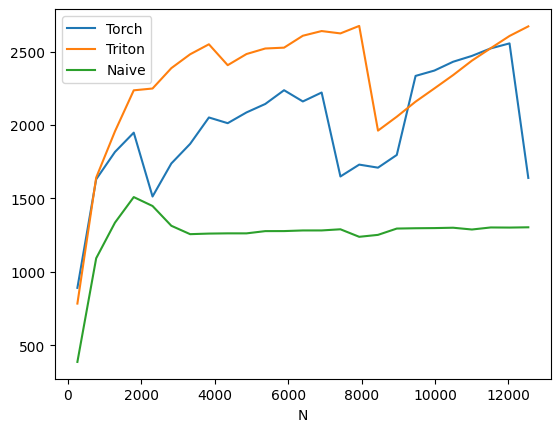

Softmax Performance:
          N        Torch       Triton        Naive
0     256.0   890.434200   783.185684   385.684644
1     768.0  1630.288553  1641.518710  1092.063484
2    1280.0  1816.452418  1956.873797  1334.759898
3    1792.0  1947.975018  2236.394603  1508.924155
4    2304.0  1512.848919  2248.795252  1448.211180
5    2816.0  1738.007150  2387.613706  1313.445034
6    3328.0  1871.390660  2481.950821  1256.282783
7    3840.0  2051.407546  2550.090032  1260.207869
8    4352.0  2012.523694  2407.765920  1261.798787
9    4864.0  2085.776197  2483.662110  1261.697556
10   5376.0  2143.447206  2521.442575  1277.006355
11   5888.0  2237.127254  2527.188329  1277.240593
12   6400.0  2160.641473  2608.334829  1281.544149
13   6912.0  2221.495931  2640.343339  1281.656465
14   7424.0  1649.389871  2624.270319  1289.504227
15   7936.0  1730.208906  2675.268799  1238.235177
16   8448.0  1709.419271  1961.844708  1251.483020
17   8960.0  1796.024484  2056.570091  1294.413539
18   9472.

In [28]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],
        x_vals=[128 * i for i in range(2, 100, 4)],
        line_arg="provider",
        line_vals=["torch", "triton", "naive"],
        line_names=["Torch", "Triton", "Naive"],
        plot_name="Softmax Performance",
        args={"M": 4096},
    )
)
def benchmark(M: int, N: int, provider: str):
    x = torch.randn(M, N, device=DEVICE)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == "torch":
        ms = triton.testing.do_bench(lambda: torch.softmax(x, dim=1))
    elif provider == "triton":
        ms = triton.testing.do_bench(lambda: triton_softmax(x))
    else:
        ms = triton.testing.do_bench(lambda: naive_softmax(x))
    gbps = 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps


benchmark.run(show_plots=True, print_data=True)